In [1]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re

In [2]:
# Loading field polygons from the Shape file (.shp)
shapefile_path = 'reference/crop_types_aut_2019_repro.shp'
field_polygons = gpd.read_file(shapefile_path)

In [3]:
# Basic information about the field polygons just (to see what I am working with)
print("Number of features (field polygons):", len(field_polygons))
print("Projection:", field_polygons.crs)
print("Columns:", field_polygons.columns)

Number of features (field polygons): 24265
Projection: PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Columns: Index(['Field_ID', 'Area_e3395', 'crop_id', 'geometry'], dtype='object')


In [4]:
# Removing all null value Field_IDs, if there are any
# converting Field_IDs to strings
field_polygons = field_polygons.dropna(subset=['Field_ID'])
field_polygons['Field_ID'] = field_polygons['Field_ID'].astype(str)

print("Number of features (field polygons):", len(field_polygons))
print("Projection:", field_polygons.crs)
print("Columns:", field_polygons.columns)

Number of features (field polygons): 22631
Projection: PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Columns: Index(['Field_ID', 'Area_e3395', 'crop_id', 'geometry'], dtype='object')


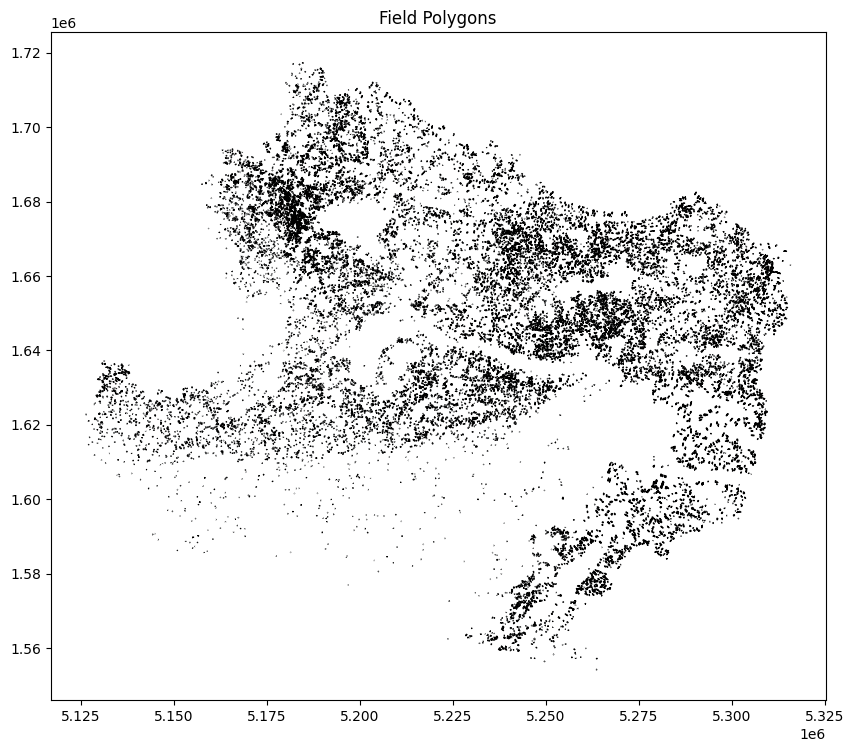

In [5]:
# Visualizing the field polygons (to see what I am working with)
fig, ax = plt.subplots(figsize=(10, 10))
field_polygons.plot(ax=ax, edgecolor='black')
plt.title('Field Polygons')
plt.show()

In [6]:
radar_image_folder = 'Sentinel - 1 CSAR/EQUI7_EU020M/E051N015T3'
radar_images = [os.path.join(radar_image_folder, f) for f in os.listdir(radar_image_folder) if f.endswith('.tif')]

In [7]:
# Extracting date from the file names
# Example - SIG0_20190402T050917__VH_D022_E051N015T3_EU020M_V0M2R4_S1BIWGRDH_TUWIEN - date: 02.04.2019, time: 05:09:17 
def extract_date_from_filename(filename):
    match = re.search(r'(\d{8})T(\d{6})', filename)
    if match:
        date_str = match.group(1)
        time_str = match.group(2)
        date = pd.to_datetime(date_str, format='%Y%m%d').date()
        time = pd.to_datetime(time_str, format='%H%M%S').time()
        return date, time
    return None, None

In [8]:
# Function to convert from dB to linear units
def db2lin(x):
    """
    Converts value from dB to linear units.

    Parameters
    ----------
    x : number
        Value in dB.

    Returns
    -------
    float
        Value in linear units.
    """
    return 10**(x/10.)

# Function to convert from linear to dB units
def lin2db(x):
    """
    Converts value from linear to dB units.

    Parameters
    ----------
    x : number
        Value in linear units.

    Returns
    -------
    float
        Value in dB.
    """
    return 10 * np.log10(x)

In [9]:
# Time series data dictionary
time_series_data = {polygon_id: [] for polygon_id in field_polygons['Field_ID']}

In [10]:
# Iterating through each radar image
for image_file in radar_images:
    acquisition_date, acquisition_time = extract_date_from_filename(image_file)
    if not acquisition_date:
        print(f"Unable to extract date from filename: {image_file}")
        continue

    print(f"Processing image: {image_file}, Acquisition date: {acquisition_date}, Acquisition time: {acquisition_time}")

    with rasterio.open(image_file) as src:
        for _, row in field_polygons.iterrows(): 
            polygon = [row['geometry']]
            polygon_id = row['Field_ID']
            
            try:
                out_image, out_transform = mask(src, polygon, crop=True)
                
                if out_image.size > 0:
                    nodata_values = [-9999, 0]
                    masked_image = np.where(np.isin(out_image, nodata_values), np.nan, out_image)

                    # Signal values are 10 times greater than expected, therefore dividng with 10
                    masked_image = masked_image / 10.0
                    linear_values = db2lin(masked_image)
                    
                    if not np.isnan(linear_values).all():
                        mean_linear_value = np.nanmean(linear_values)

                        mean_db_value = lin2db(mean_linear_value)
                        
                        time_series_data[polygon_id].append((acquisition_date, mean_db_value))
            except Exception as e:
                print(f"Error processing polygon {polygon_id} in image {image_file}: {e}")

Processing image: Sentinel - 1 CSAR/EQUI7_EU020M/E051N015T3\SIG0_20190303T050953__VH_D022_E051N015T3_EU020M_V0M2R4_S1AIWGRDH_TUWIEN.tif, Acquisition date: 2019-03-03, Acquisition time: 05:09:53
Processing image: Sentinel - 1 CSAR/EQUI7_EU020M/E051N015T3\SIG0_20190309T050917__VH_D022_E051N015T3_EU020M_V0M2R4_S1BIWGRDH_TUWIEN.tif, Acquisition date: 2019-03-09, Acquisition time: 05:09:17
Processing image: Sentinel - 1 CSAR/EQUI7_EU020M/E051N015T3\SIG0_20190315T050953__VH_D022_E051N015T3_EU020M_V0M2R4_S1AIWGRDH_TUWIEN.tif, Acquisition date: 2019-03-15, Acquisition time: 05:09:53
Processing image: Sentinel - 1 CSAR/EQUI7_EU020M/E051N015T3\SIG0_20190321T050917__VH_D022_E051N015T3_EU020M_V0M2R4_S1BIWGRDH_TUWIEN.tif, Acquisition date: 2019-03-21, Acquisition time: 05:09:17
Processing image: Sentinel - 1 CSAR/EQUI7_EU020M/E051N015T3\SIG0_20190327T050953__VH_D022_E051N015T3_EU020M_V0M2R4_S1AIWGRDH_TUWIEN.tif, Acquisition date: 2019-03-27, Acquisition time: 05:09:53
Processing image: Sentinel - 1

In [15]:
# Visualizing the time series for a selected polygon (to see if the extraction was successfull)
def plot_time_series(polygon_id, time_series_data):
    if polygon_id not in time_series_data:
        print(f"Polygon ID {polygon_id} not found in time series data.")
        return

    time_series = time_series_data[polygon_id]
    if not time_series:
        print(f"No data available for Polygon ID {polygon_id}.")
        return

    dates, signal_values = zip(*time_series)
    dates = pd.to_datetime(dates)

    plt.figure(figsize=(10, 6))
    plt.plot(dates, signal_values, marker='o', linestyle='-')
    plt.title(f'Time Series of Radar Signal Values for Polygon {polygon_id}')
    plt.xlabel('Date')
    plt.ylabel('Radar Signal Value (dB)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

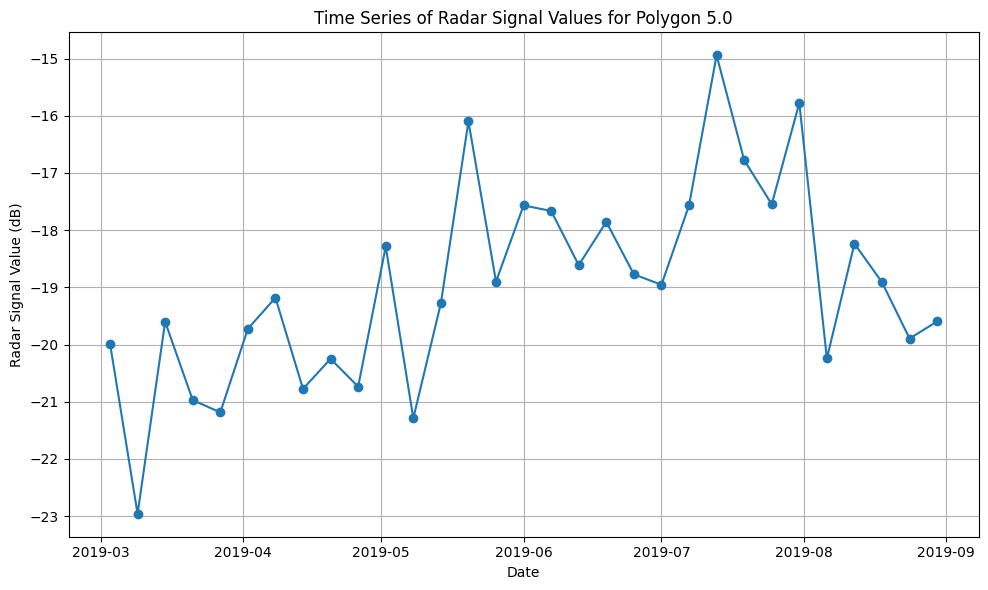

In [16]:
# Sample polygon
plot_time_series('5.0', time_series_data) 

In [13]:
def save_time_series_to_csv(time_series_data, field_polygons, filename):
    rows = []
    for polygon_id, time_series in time_series_data.items():
        polygon_data = field_polygons[field_polygons['Field_ID'] == polygon_id].iloc[0]
        for date, value in time_series:
            row = [polygon_id, date, value]
            row.extend([polygon_data['crop_id']])
            rows.append(row)

    df = pd.DataFrame(rows, columns=['Polygon_ID', 'Date', 'Radar_Signal_Value', 'Crop_ID'])
    df.to_csv(filename, index=False)

In [14]:
save_time_series_to_csv(time_series_data, field_polygons, 'time_series_dataset.csv')